# Will an AirBnb host receive a perfect rating?
### Classifying "perfect" hosts using logistic regression and SVM ###

__Cleaning the data__  
First, we removed variables with high correlation, repetitive values, and attributes with a high number of missing values to narrow our focus of predictors and performed data transformations to aid our analysis.  
    
Our target classification variable is a Boolean indicator for whether or not a host received a "perfect" 100 review score. Through our classification and analysis, we will determine which attributes are most powerfully associated with a 100 rating.

In [59]:
import pandas as pd
import numpy as np
from decimal import Decimal
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
 
data = pd.read_csv("/Users/jazis/Downloads/listings.csv")

#data cleaning from LAB1
#drop redundant info and fields not useful for analysis
sub=data.drop(['id','listing_url','scrape_id','last_scraped','summary','space','description','experiences_offered'
              , 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
              'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url',
              'host_picture_url', 'country_code', 'country','amenities', 'minimum_minimum_nights',
              'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm',
              'maximum_nights_avg_ntm', 'availability_30', 'availability_365','availability_90','has_availability',
               'calculated_host_listings_count','calculated_host_listings_count_shared_rooms',
               'is_business_travel_ready','host_about', 'host_acceptance_rate', 'host_total_listings_count',
              'jurisdiction_names','license','monthly_price','square_feet','weekly_price', 'requires_license'], axis=1)
def money_to_decimal(x):
    x = x.replace("$", "").replace(",", "").replace(" ", "")
    return float(x)
def rem_percent(x):
    x=x.replace("%","")
    return float(x)/100
def truncate(n):
    return int(n * 1000) / 1000
#converts objects with money values into decimal values to become continous attribute
sub.cleaning_fee = sub.cleaning_fee.astype(str)
sub.extra_people = sub.extra_people.astype(str)
sub.security_deposit = sub.security_deposit.astype(str)
sub.price = sub.price.astype(str)
sub.loc[:,'price'] = sub.loc[:,'price'].apply(money_to_decimal)
sub.loc[:,'cleaning_fee'] = sub.loc[:,'cleaning_fee'].apply(money_to_decimal)
sub.loc[:,'extra_people'] = sub.loc[:,'extra_people'].apply(money_to_decimal)
sub.loc[:,'security_deposit'] = sub.loc[:,'security_deposit'].apply(money_to_decimal)

#imputations
sub['price']=sub.price.mask(sub.price == 0,sub.price.median())
sub.cleaning_fee=sub.cleaning_fee.fillna(sub.cleaning_fee.median())
sub.first_review=sub.first_review.fillna('2019-08-01')
sub['first_review'] =  pd.to_datetime(sub['first_review'],
                              format='%Y-%m-%d')
sub.host_response_rate = sub.host_response_rate.astype(str)
sub.loc[:,'host_response_rate'] = sub.loc[:, 'host_response_rate'].apply(rem_percent)
sub.host_response_rate=sub.host_response_rate.fillna(sub.host_response_rate.median())
sub['host_since'] =  pd.to_datetime(sub['host_since'],
                              format='%Y-%m-%d')
sub.last_review=sub.last_review.fillna('2019-08-01')
sub['last_review'] =  pd.to_datetime(sub['last_review'],
                              format='%Y-%m-%d')
sub.review_scores_accuracy=sub.review_scores_accuracy.fillna(truncate(sub.review_scores_accuracy.median()))
sub.review_scores_checkin=sub.review_scores_checkin.fillna(truncate(sub.review_scores_checkin.median()))
sub.review_scores_cleanliness=sub.review_scores_cleanliness.fillna(truncate(sub.review_scores_cleanliness.median()))
sub.review_scores_communication=sub.review_scores_communication.fillna(truncate(sub.review_scores_communication.median()))
sub.review_scores_location=sub.review_scores_location.fillna(truncate(sub.review_scores_location.median()))
#sub.review_scores_rating=sub.review_scores_rating.fillna(truncate(sub.review_scores_rating.median()))
sub.review_scores_value=sub.review_scores_value.fillna(truncate(sub.review_scores_value.median()))
sub.reviews_per_month=sub.reviews_per_month.fillna(sub.reviews_per_month.median())
sub.security_deposit=sub.security_deposit.fillna(sub.security_deposit.median())
sub.bathrooms=sub.bathrooms.fillna(sub.bathrooms.median())
sub.bedrooms=sub.bedrooms.fillna(sub.bedrooms.median())
sub.host_listings_count=sub.host_listings_count.fillna(sub.host_listings_count.median())
sub.beds=sub.beds.fillna(sub.beds.median())
#sub.host_response_time=sub.host_response_time.fillna('missing')


C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


__Creating dummy variables for logisitic regression__

We created dummy variables for the categorical variables that we would include in the model. We iteratively determined which categorical variables to include by checking the accuracy of each interim model when removing terms.

In [60]:
df = sub[~sub['review_scores_rating'].isnull()]
df['perf_score'] = np.where(df['review_scores_rating']==100, 1, 0)
df.perf_score.sum()
df_data=df
#df_data_x=df.drop('perf_score', axis=1)
##df_data['zipcode'] = df['zipcode'].str.extract('(^\d+)', expand=False)
df_y=df['perf_score']

#create dummy vars
##host_loc = pd.get_dummies(df_data['host_location'],drop_first=True)
host_response = pd.get_dummies(df_data['host_response_time'],drop_first=True)
##host_neigh = pd.get_dummies(df_data['neighbourhood_group_cleansed'],drop_first=True)
##host_verif = pd.get_dummies(df_data['host_verifications'],drop_first=True)
df_data['host_identity_verified'] = pd.get_dummies(df_data['host_identity_verified'],drop_first=True)
##street = pd.get_dummies(df_data['street'],drop_first=True)
neighborhood = pd.get_dummies(df_data['neighbourhood_group_cleansed'],drop_first=True)
##city = pd.get_dummies(df_data['city'],drop_first=True)
# make into continuous zipcode = pd.get_dummies(x_train['zipcode'],drop_first=True)
##market = pd.get_dummies(df_data['market'],drop_first=True)
df_data['is_location_exact'] = pd.get_dummies(df_data['is_location_exact'],drop_first=True)
prop_type = pd.get_dummies(df_data['property_type'],drop_first=True)
room_type = pd.get_dummies(df_data['room_type'],drop_first=True)
bed_type = pd.get_dummies(df_data['bed_type'],drop_first=True)
df_data['instant_bookable'] = pd.get_dummies(df_data['instant_bookable'],drop_first=True)
cancel = pd.get_dummies(df_data['cancellation_policy'],drop_first=True)
df_data['host_is_superhost'] = pd.get_dummies(df_data['host_is_superhost'],drop_first=True)

df_data.drop(['host_location','host_response_time','host_neighbourhood','host_verifications',
             'street', 'neighbourhood', 'city', 'market', 
             'property_type', 'room_type', 'bed_type', 'instant_bookable',
             'cancellation_policy', 'name', 'host_name', 'host_has_profile_pic', 'neighbourhood_cleansed',
              'neighbourhood_group_cleansed', 'host_neighbourhood', 'smart_location', 'calendar_updated',
             'calendar_last_scraped','require_guest_profile_picture', 'require_guest_phone_verification',
             'host_since', 'first_review', 'last_review', 'state', 'smart_location', 'zipcode','review_scores_rating'],axis=1,inplace=True)

df_data = pd.concat([df_data, host_response, prop_type, room_type,
                    bed_type, cancel, neighborhood],axis=1)

##x_train, x_test, y_train, y_test = train_test_split(df_data, df_y, test_size=0.2)


C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

__Fitting the logistic model__

In [61]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:

if 'perf_score' in df_data:
    y = df_data['perf_score'].values # get the labels we want
    del df_data['perf_score'] # get rid of the class label
    X = df_data.values # use everything else to predict!


    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [62]:
from sklearn import metrics as mt
import matplotlib.pyplot as plt
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 0  ====
accuracy 0.7101430084745762
confusion matrix
 [[5363    0]
 [2189    0]]


C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


====Iteration 1  ====
accuracy 0.703125
confusion matrix
 [[5310    0]
 [2242    0]]
====Iteration 2  ====
accuracy 0.7123940677966102
confusion matrix
 [[5380    0]
 [2172    0]]


C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


__How accurate is the logisitic model?__  
The logistic regression model fails to predict any perfect review scores. The model is able to predict non-perfect scores well, giving it an overall accuracy of 70%. Since only about 20% of the data has a perfect score, it is not suprising that the model better predicts non-perfect scores since it has more observations from which to learn. However, this is not an ideal prediction model, and we will assess alternatives to improve.

__Interpreting the weights__  

In [63]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_data.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

host_id has weight of -5.480348324816679e-09
host_response_rate has weight of -1.9393212671760496e-16
host_is_superhost has weight of -8.24678911280359e-17
host_listings_count has weight of 5.038031356061351e-16
host_identity_verified has weight of -1.3527562403797466e-16
latitude has weight of -8.264461536829214e-15
longitude has weight of 1.5004881706940184e-14
is_location_exact has weight of -1.6941025124525535e-16
accommodates has weight of -6.291025797221729e-16
bathrooms has weight of -2.2081190935267456e-16
bedrooms has weight of -2.4026640344587224e-16
beds has weight of -3.42917085838796e-16
price has weight of -2.2794550053200986e-14
security_deposit has weight of -3.742528811563926e-14
cleaning_fee has weight of -1.1346804916748766e-14
guests_included has weight of -3.685129284607418e-16
extra_people has weight of -4.3312501913228435e-15
minimum_nights has weight of -9.328286351740973e-16
maximum_nights has weight of -1.2360857942622036e-13
availability_60 has weight of -3.7

Since each attribute has its own scale, we will make the weights comparable by normalizing each weight by the attribute's mean and standard deviation and refitting the model.

In [64]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

#acc = mt.accuracy_score(y_test,y_hat)
#conf = mt.confusion_matrix(y_test,y_hat)
#print("accuracy", acc)
#print("confusion matrix\n",conf)


# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_data.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


number_of_reviews has weight of -4.065317262006493
number_of_reviews_ltm has weight of -0.3048619123128037
reviews_per_month has weight of -0.22287129257077168
strict_14_with_grace_period has weight of -0.18611536833154088
moderate has weight of -0.12590347803725763
Tiny house has weight of -0.0817722036945649
Cottage has weight of -0.05867426127494084
host_identity_verified has weight of -0.05187701919553245
calculated_host_listings_count_entire_homes has weight of -0.048794357875734364
longitude has weight of -0.045724324064914765
Camper/RV has weight of -0.04548234731014271
accommodates has weight of -0.04247357196727655
extra_people has weight of -0.037800494786396736
beds has weight of -0.03745306538269009
guests_included has weight of -0.037065744182251385
Cave has weight of -0.03598153052154802
super_strict_30 has weight of -0.024834460149824898
Shared room has weight of -0.023392895044463752
within an hour has weight of -0.0220570394521907
Nature lodge has weight of -0.02086857

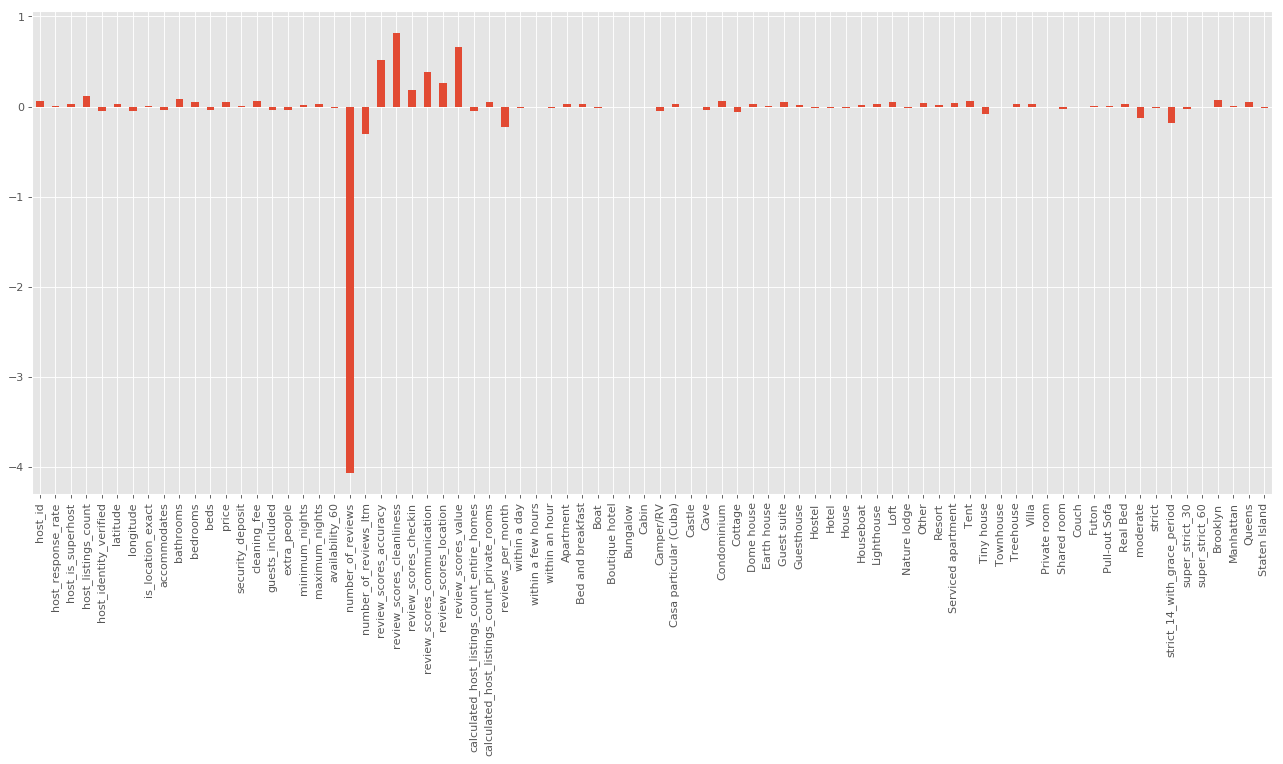

In [65]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.style.use('ggplot')

figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

weights = pd.Series(lr_clf.coef_[0],index=df_data.columns)
weights.plot(kind='bar')
plt.show()

__Assessing the weights__  
The normalization now allows us to compare the coefficient values directly with each other and determine which variables provide more information on classifying a host's perfect score or non-perfect score based on their listing attributes.    

The specific host review scores are unsurprisingly associated with the overall host review with weights ranging from 0.22 (check-in score) to 0.80 (cleanliness score).   

The coefficients with the strongest weights are related to the number of reviews that the listing has: Number_of_reviews has -4.15, number_of_reviews_ltm (the number of long-term stay reviews) has -0.34, and reviews_per_month has -0.201. This is likely due to the fact that there are more occurrences where guests have the opportunity to provide a non-perfect score.   

Strict_14_with_grace_period also has one of the heavier weights with -0.16, meaning hosts with a strict cancelation policy with a 14-day grace period tend to not have perfect ratings. This could infer a less overall flexible relationship between hosts and guests, leading to more critical guest reviews.  

Host_listings_count has a weight of 0.12. The number of total listings a host has contributes to a perfect score.    

The remaining variables have weights less than 0.10, so they do not as significantly influence the classification of the host's score. Many of these variables are levels of a categorical variable, meaning the weight of each level only reflects a partial contribution of the inclusion of the categorical variable, explaining why these classes do not appear significant. However, the presence of these variables were validified by the improved accuracy when building the model.   

Other continuous variables that do not have heavy weights, such as cleaning_fee, price, beds, accommodates, etc., likely have less importance because they are determining factors for selecting a listing, providing less information about the experience the guest had during their stay and how expectations were met. 
The normalization now allows us to compare the coefficients values directly with each other and determine which variables provide more information on classifying a host's perfect score or non-perfect score based on their listing attributes.    

The specific host review scores are unsurprisingly associated with the overall host review with weights ranging from 0.22 (check-in score) to 0.80 (cleanliness score).   

The coefficients with the strongest weights are related to the number of reviews that the listing has. Number_of_reviews has -4.15, number_of_reviews_ltm (the number of long-term stay reviews) has -0.34, and reviews_per_month has -0.201. This is likely due to the fact that there are more occurrences where guests have the opportunity to provide a non-perfect score.   

Strict_14_with_grace_period also has one of the heavier weights with -0.16, meaning hosts with a strict cancelation policy with a 14 day grace period tend to not have perfect ratings. This could reflect a less overall flexible relationship between hosts and guests, leading to more critical guest reviews.  

Host_listings_count has a weight of 0.12, the number of total listings a host has contributes to a perfect score.    

The remaining variables have weights less than 0.10, so they do not as significantly influence the classification of the host's score. Many of these variables are levels of a categorical variable, meaning the weight of each level only reflects a partial contribution of the inclusion of the categorical variable, explaining why these classes do not appear significant. However, the presence of these variables was validified by the improved accuracy when building the model.   

Other continuous variables that do not have heavy weights, such as cleaning_fee, price, beds, accommodates, etc., likely have less importance because they are determining factors for selecting a listing, providing less information about the experience the guest had during their stay and how expectations were met. 

__Fitting the Support Vector Machine__  

In [47]:
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [49]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)
##took longer to run

accuracy: 0.8395127118644068
[[4828  498]
 [ 714 1512]]


__SVM Performance__  
The support vector machine outperformed the logistic model with 84% accuracy. The logistic model was only able to predict non-perfect scores -- in which the majority of reviews fall. However, we are more interested in being able to accurately predict when a customer will leave a perfect review which occurs far less frequently. This logistic model was able to identify both with 91% accuracy identifying true-negatives (less than perfect scores) and 68% accuracy identifying true-positives (perfect scores).

__SVM Advantage__  
This model outperforms the logistic model in terms of accuracy. Although this model does take longer to run than the logistic model, because this dataset is not that large, the extra few seconds it takes to run is not a big disadvantage. This classification model is also advantageous because SVMs tend to perform better with higher dimensional models, are less sensitive to outliers, and are less computationally intensive. This is important because we include several categorical variables that have numerous unique levels (ranging from 2 to 222) in our predictive model that have been broken out into dummy variables.

In [67]:
# looking at the support vectors
print(svm_clf.support_vectors_.shape) #(observations, variables) to be support vectors
print(svm_clf.support_.shape) #(observations,) on the edge of vector
print(svm_clf.n_support_ ) #([observations on the edge for one class/ obs on edge for the other class ])

(12988, 80)
(12988,)
[6639 6349]


In [71]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grab the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_data.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['perf_score'] = y[svm_clf.support_] # add back in the 'perf_score' column to the pandas dataframe
df_data['perf_score'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12988 entries, 32052 to 34362
Data columns (total 81 columns):
host_id                                         12988 non-null int64
host_response_rate                              12988 non-null float64
host_is_superhost                               12988 non-null uint8
host_listings_count                             12988 non-null float64
host_identity_verified                          12988 non-null uint8
latitude                                        12988 non-null float64
longitude                                       12988 non-null float64
is_location_exact                               12988 non-null uint8
accommodates                                    12988 non-null int64
bathrooms                                       12988 non-null float64
bedrooms                                        12988 non-null float64
beds                                            12988 non-null float64
price                                        

C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\jazis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

LinAlgError: singular matrix

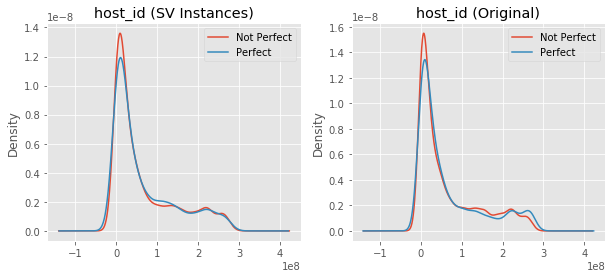

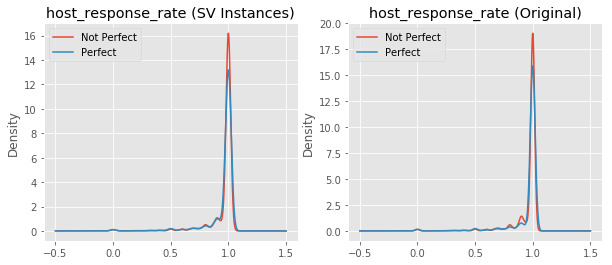

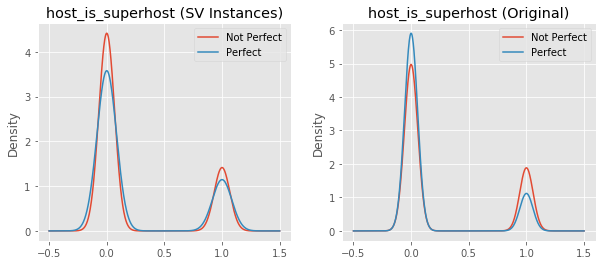

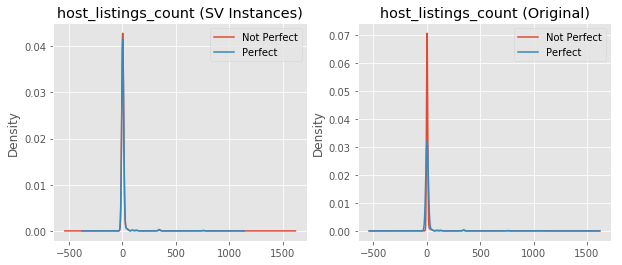

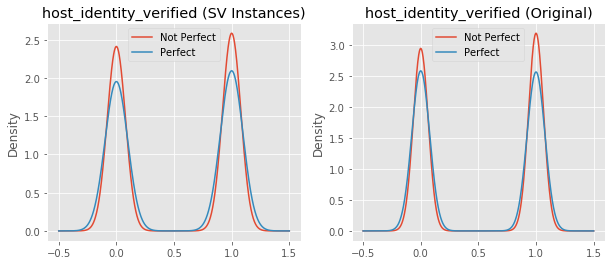

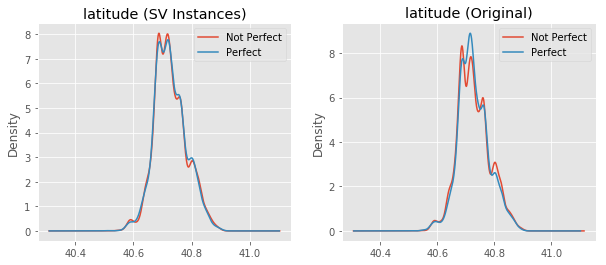

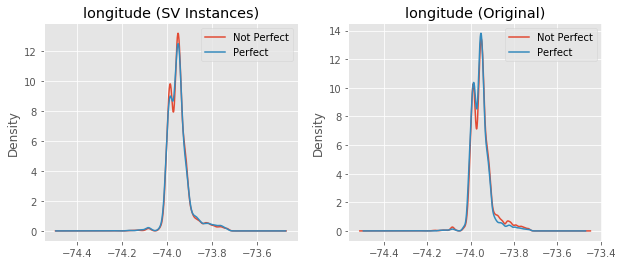

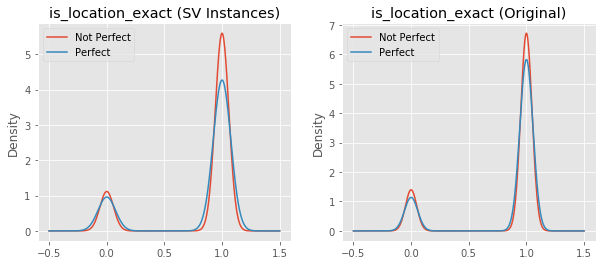

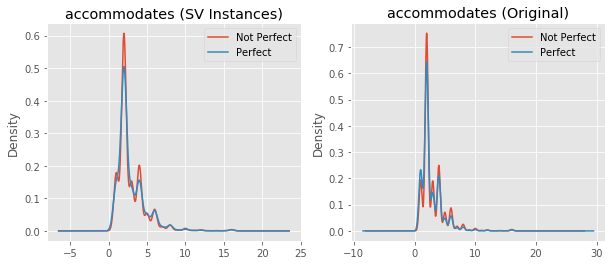

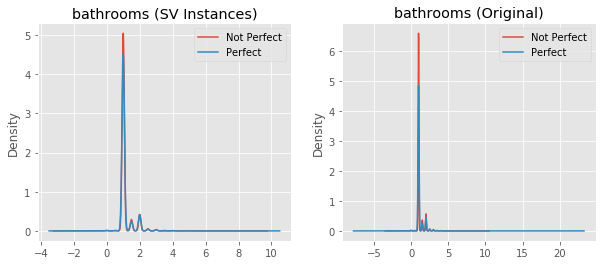

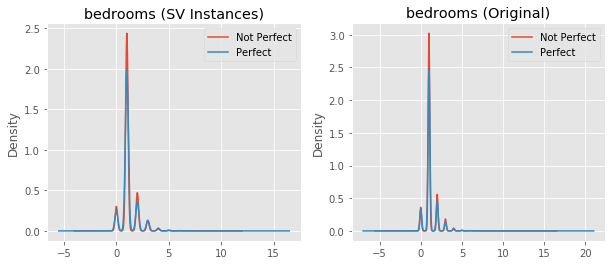

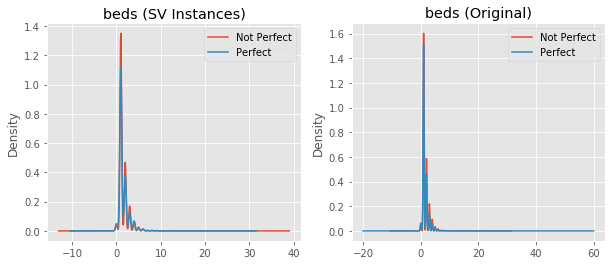

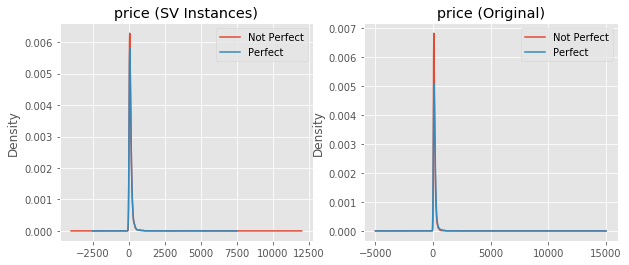

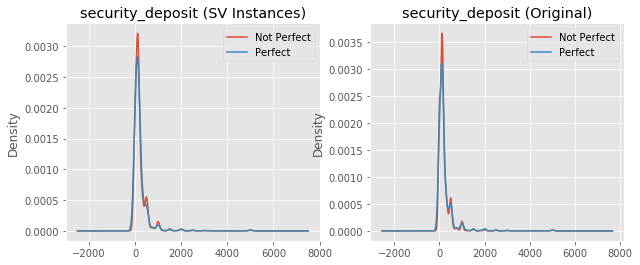

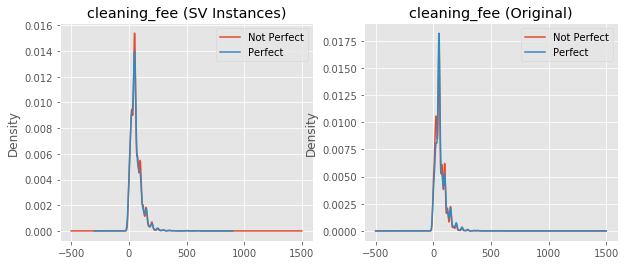

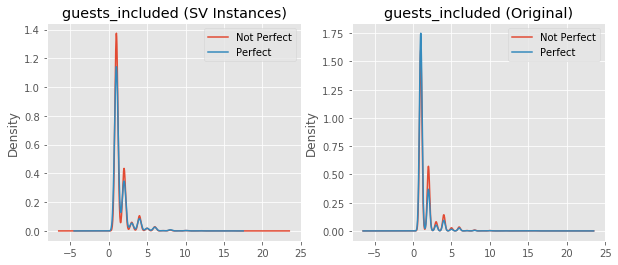

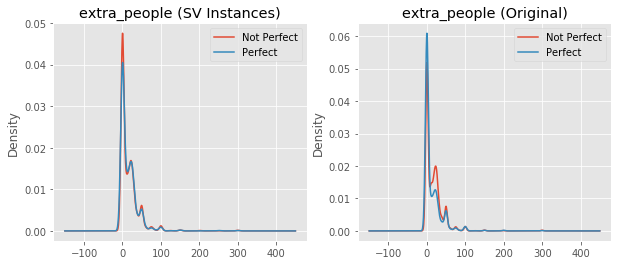

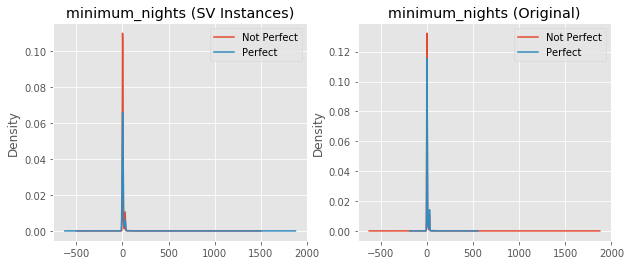

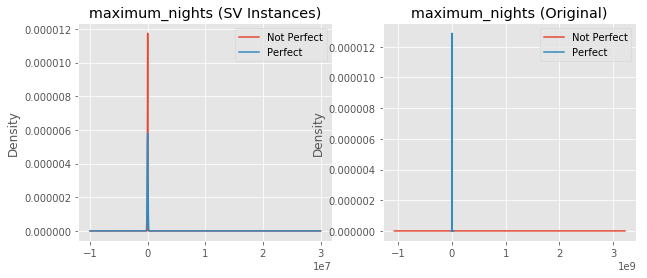

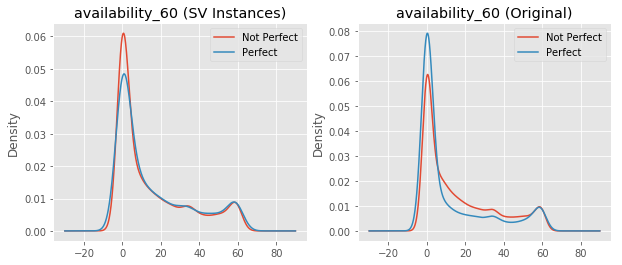

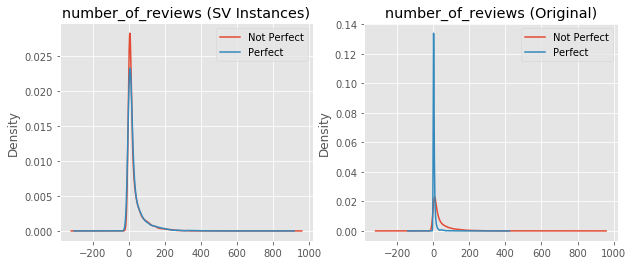

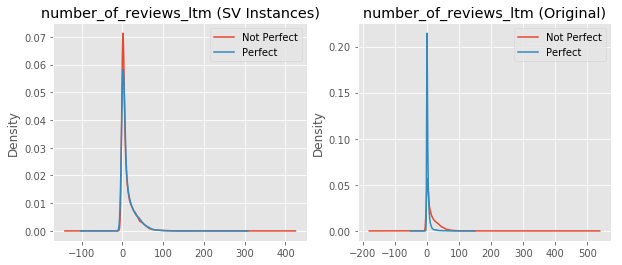

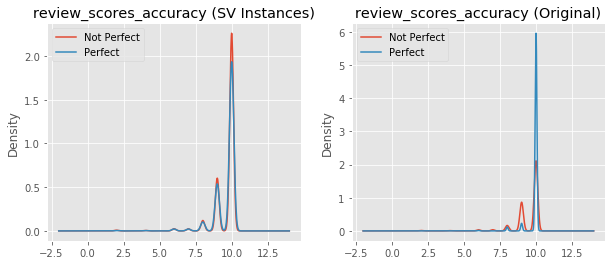

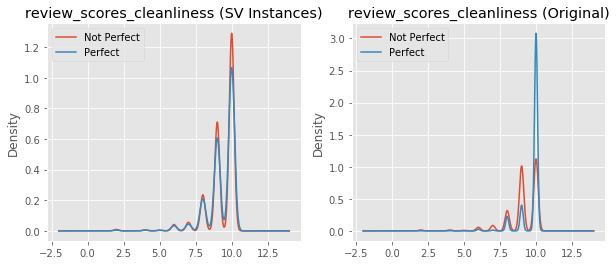

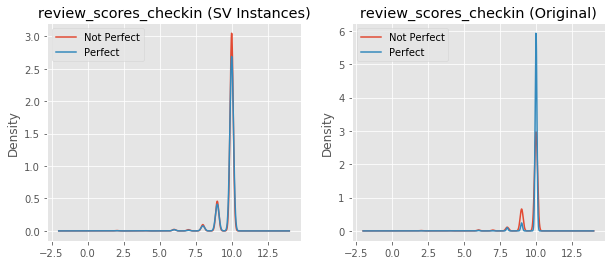

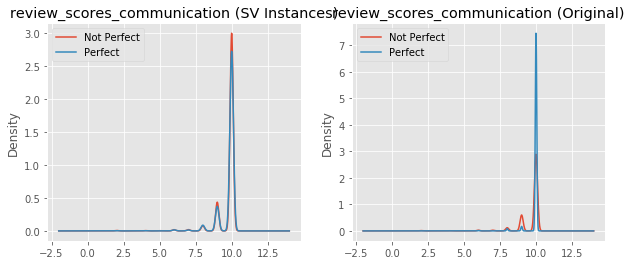

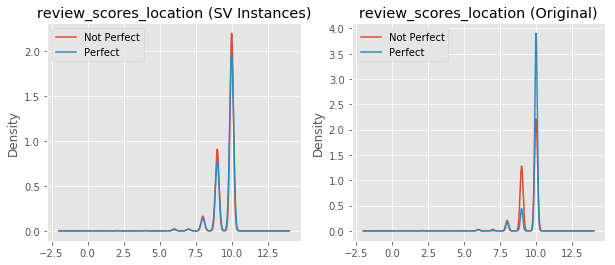

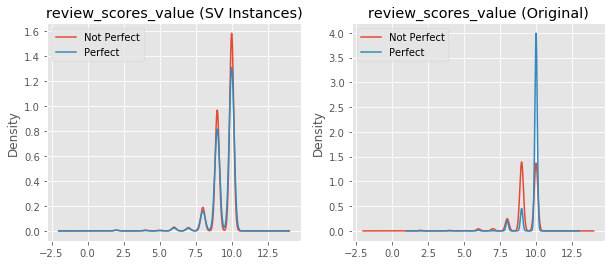

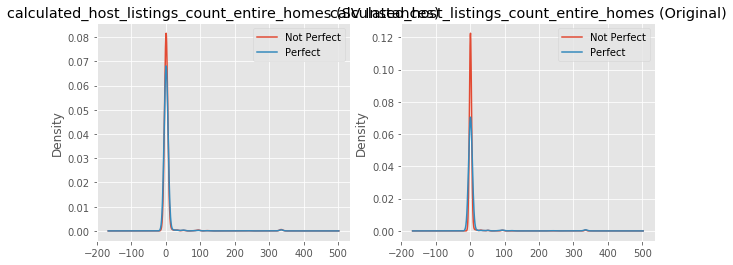

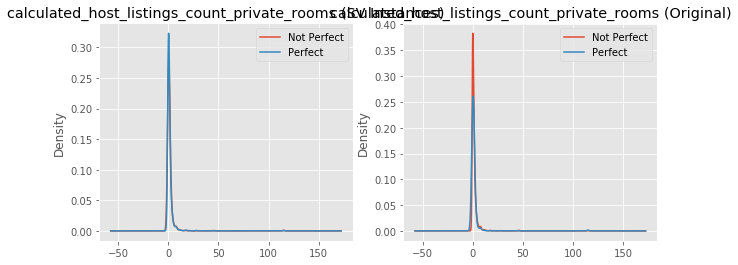

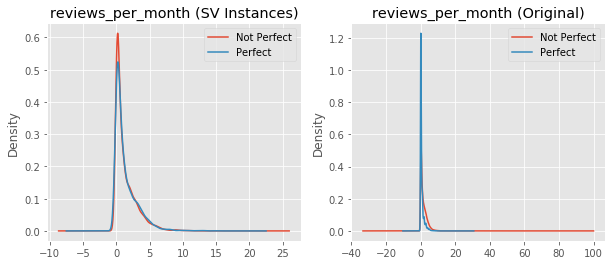

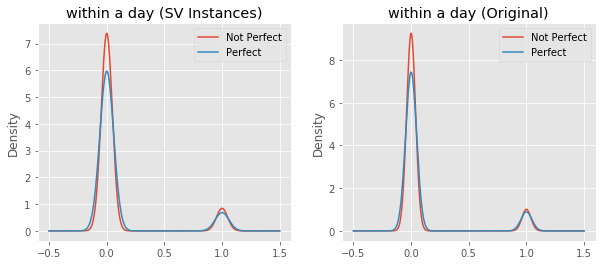

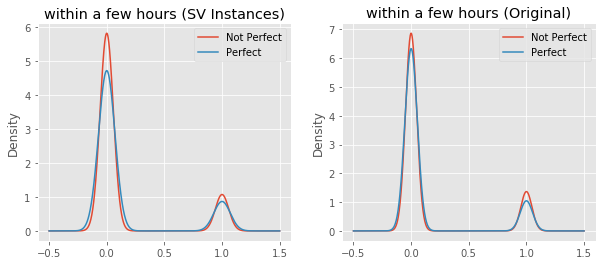

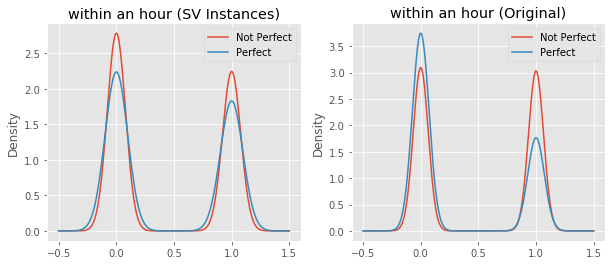

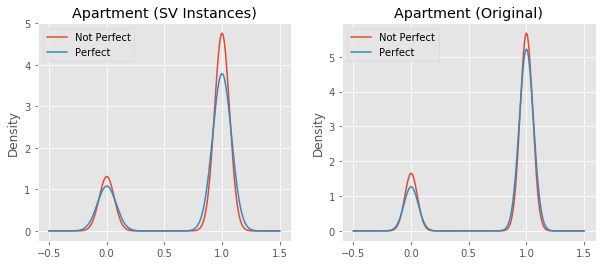

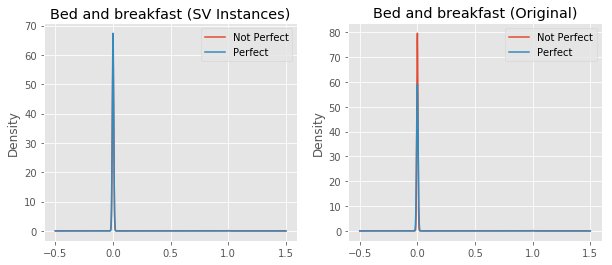

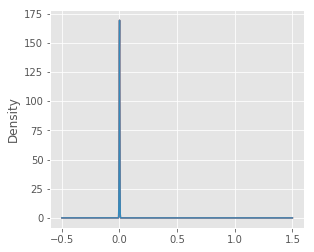

In [72]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['perf_score'])
df_grouped = df_data.groupby(['perf_score'])

# plot KDE of Different variables
vars_to_plot = ['host_id',
'host_response_rate',
'host_is_superhost',
'host_listings_count',
'host_identity_verified',
'latitude',
'longitude',
'is_location_exact',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'price',
'security_deposit',
'cleaning_fee',
'guests_included',
'extra_people',
'minimum_nights',
'maximum_nights',
'availability_60',
'number_of_reviews',
'number_of_reviews_ltm',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location',
'review_scores_value',
'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms',
'reviews_per_month',
'within a day',
'within a few hours',
'within an hour',
'Apartment',
'Bed and breakfast',
'Boat',
'Boutique hotel',
'Bungalow',
'Cabin',
'Camper/RV',
'Casa particular (Cuba)',
'Castle',
'Cave',
'Condominium',
'Cottage',
'Dome house',
'Earth house',
'Guest suite',
'Guesthouse',
'Hostel',
'Hotel',
'House',
'Houseboat',
'Lighthouse',
'Loft',
'Nature lodge',
'Other',
'Resort',
'Serviced apartment',
'Tent',
'Tiny house',
'Townhouse',
'Treehouse',
'Villa',
'Private room',
'Shared room',
'Couch',
'Futon',
'Pull-out Sofa',
'Real Bed',
'moderate',
'strict',
'strict_14_with_grace_period',
'super_strict_30',
'super_strict_60',
'Brooklyn',
'Manhattan',
'Queens',
'Staten Island']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Perfect','Perfect'])
    plt.title(v+' (SV Instances)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Perfect','Perfect'])
    plt.title(v+' (Original)')



__SVM Chosen Support Vectors__  
The model identified ~13000 records in the dataset across 80 variables that were on the border of being misclassified which created 80 support vectors. These vectors include variables pertaining to the cancellation policy, location (neighborhood and coordinates), accommodations (property type, bed type, rooms, etc.), host characteristics (id, response time, verified, number of listings, etc.), prices and fees and other rating categories. The support vectors range to include many different types of variables, but there is no specific category that stands out. However, many of the support vectors are from levels of a categorical variable that had very small volumes (like castle, caves, pull-out sofa) or many unique values (like host id or price). It makes sense that the model would have a harder time predicting a classification class when there is very little training data available. 